# Group Assignment QF627

<font size = 5>**Group Members:**</font>
* Anna Germaine Lim
* Chen Pengyu
* Gregory Tan
* Zenith Tay

# Contribution Statement

Name        |Work Contributed                                                                           |
---         |   ---                                                                                     |
Zenith      |Supervised Learning Models and Codes, Report Writing, Team Reflections                           |
Gregory     |   Momentum Trading Strategies and Codes, Report Writing and Collation, Team Reflections             |
Anna        |Mean-Reversion Strategies and Codes, Report Writing, Team Reflections                                |
Pengyu      |Report Writing, Team Reflections, Attempts on unsupervised learning                        |

# Prep Work

## Packages Used in This Workbook

In [75]:
## Data Download

import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as pdr

## For Visualisation

In [76]:
### For Supervised learning

# Model specification

# linear models
from sklearn.linear_model import LinearRegression # Linear Regression
from sklearn.linear_model import ElasticNet # Elastic Net
from sklearn.linear_model import Lasso # LASSO

# oldies
from sklearn.svm import SVR # Support Vector Machine
from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbor

# decision tree
from sklearn.tree import DecisionTreeRegressor# Decision Tree

# bagging
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import ExtraTreesRegressor # Extra Trees

# boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Boosting Tree
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting

# time-series
import statsmodels.tsa.arima.model as stats # ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# Data split
from sklearn.model_selection import train_test_split

# feature engineering

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

## Functions

### Download of Data

In [77]:
start_date = "2006-11-01"
end_date = "2025-11-13"

In [78]:
def download_data (ticker: list[str] | str,
                   start_date = start_date, 
                   end_date = end_date,
                   close_only = False) -> pd.DataFrame:
    if close_only == False:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
        )
    else:
        data =\
        (
            yf.download(tickers = ticker,
                        start = start_date,
                        end = end_date)
                        ["Close"]
        )    

    return data

In [79]:
# preallocate empty array and assign slice by chrisaycock

def np_shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

### Performance Metrics

In [80]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

In [81]:
## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

In [82]:
### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd


### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

In [83]:
def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

In [84]:
def generate_returns(price_data: pd.DataFrame,
                     price_col: 'str' = 'Close') -> pd.Series:
    
    returns_series = price_data[price_col].pct_change()
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = float(cum_returns_series.iloc[-1].iloc[0])

    print('=== Summary of Returns === \n',
          f'Total Returns = {tot_returns: .2%}'
          )

    return tot_returns, returns_series, cum_returns_series

## Download Dataset

In [85]:
spy_data =\
(
    download_data("SPY", start_date, end_date)
)
spy_data

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_24384\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2006-11-01,95.973625,96.990441,95.875450,96.927331,83005600
2006-11-02,95.917519,96.078804,95.622993,95.728177,60693100
2006-11-03,95.749237,96.345307,95.104085,96.261160,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400


In [86]:
spy_data = \
    (
        spy_data
        .droplevel(
            level = 1,
            axis =1
        )
    )

# Part 1 and 2: Analysis, Visualisation and Strategy

Data Wrangling and Preparation

In [193]:
train_pct = 0.75
train_test_split_index = int(train_pct*len(spy_data))

spy_train_data =\
    (
        spy_data
        .copy()
        .iloc[ : train_test_split_index]
    )

spy_test_data =\
    (
        spy_data
        .copy()
        .iloc[train_test_split_index : ]
    )

In [88]:
len(spy_train_data) + len(spy_test_data)

4788

In [89]:
display(spy_train_data, spy_train_data)

Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973625,96.990441,95.875450,96.927331,83005600
2006-11-02,95.917519,96.078804,95.622993,95.728177,60693100
2006-11-03,95.749237,96.345307,95.104085,96.261160,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2021-02-02,357.220398,358.783923,352.323908,355.441557,64450700
2021-02-03,357.501190,359.233230,356.218553,358.053565,52427100
2021-02-04,361.564484,361.611284,357.613572,358.540435,47142600


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,95.973625,96.990441,95.875450,96.927331,83005600
2006-11-02,95.917519,96.078804,95.622993,95.728177,60693100
2006-11-03,95.749237,96.345307,95.104085,96.261160,71346400
2006-11-06,96.829132,96.969381,96.036712,96.043731,63303300
2006-11-07,97.200813,97.460274,96.773048,96.913297,63318900
...,...,...,...,...,...
2021-02-02,357.220398,358.783923,352.323908,355.441557,64450700
2021-02-03,357.501190,359.233230,356.218553,358.053565,52427100
2021-02-04,361.564484,361.611284,357.613572,358.540435,47142600


## (1A) Momentum Trading Strategy

### Functions to Generate Positions and Signals

In [90]:
## Moving Average

def generate_moving_avg(price_data: pd.Series,
                        window: int
                                              ) -> pd.Series:
    
    ma_series =\
    (
        pd.Series
        (   
            price_data
            .rolling(window = window)
            .mean(),

            name = 'MA' + str(window)
        )
    )

    return ma_series

In [91]:
## Exponential Moving Average

def generate_EMA(price_data: pd.Series, 
                    window: int
                            ) -> pd.Series:
    EMA = pd.Series(price_data
                    .ewm(span = window,
                         min_periods = window)
                    .mean(),
                    name = "EMA_" + str(window)
                    )
    return EMA

In [92]:
def generate_moving_avg_cross_signal(long_ma: pd.Series,
                                    short_ma: pd.Series) -> pd.Series:
    
    ## Sanity Check
    if len(long_ma) != len(short_ma):
        print('MA series lengths not equal, please check')
        return

    ## Return Signals
    else:

        moving_avg_cross_positions = np.where(short_ma > long_ma, 1.0, 0.0)
        moving_avg_cross_positions = np.where(short_ma < long_ma, -1.0 , moving_avg_cross_positions)

        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions,1) > 0, 1, 0)
        moving_avg_cross_signals = np.where(moving_avg_cross_positions - np_shift(moving_avg_cross_positions, 1) < 0, -1, moving_avg_cross_signals)

        buy_or_sell = pd.DataFrame({'MA_Cross_Signal':moving_avg_cross_signals, 'MA_Cross_Position': moving_avg_cross_positions},
                                   index = long_ma.index
                                   )

        return buy_or_sell

In [93]:
## Rate of Change

def generate_rate_of_change(price_data: pd.Series,
                            n: int
                            ) -> pd.Series:
    
    ROC = pd.Series(
                        (price_data - price_data.diff(n)) / price_data.diff(n),
                        name = 'ROC'+str(n),
                        # index = price_data.index
                    )
    
    return ROC

In [94]:
def generate_rate_of_change_signal(roc_data: pd.Series) -> pd.Series:

    roc_position = pd.Series(np.where(roc_data > 0, 1.0, 0.0), index=roc_data.index, name = 'ROC_Position')
    roc_signal = roc_position.diff()
    roc_signal.name = 'ROC_Signal'
    
    # roc_signal = roc_position - np_shift(roc_position, 1)


    # buy_or_sell = pd.DataFrame({'ROC_Position': roc_position, 'ROC_Signal': roc_signal},
    #                         #    index = roc_data.index
    #                            )

    return pd.concat([roc_position, roc_signal], axis=1)

In [207]:
## RSI

def generate_RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return pd.Series( (100 - 100 / (1 + rs)),
                     name = f'RSI{period}'
                )

In [96]:
def generate_rsi_signal(rsi_data: pd.Series) -> pd.Series:

    rsi_position = pd.Series(np.where(rsi_data > 50, 1.0, -1.0), 
                             index= rsi_data.index, 
                             name = 'rsi_position')
    
    rsi_signal = rsi_position.diff()
    rsi_signal.name = 'rsi_signal'
    
    # rsi_signal = rsi_position - np_shift(rsi_position, 1)


    # buy_or_sell = pd.DataFrame({'rsi_position': rsi_position, 'rsi_signal': rsi_signal},
    #                         #    index = rsi_data.index
    #                            )

    return pd.concat([rsi_position, rsi_signal], axis=1)

In [97]:
def generate_force_index(data_price: pd.Series, data_vol: pd.Series, period: int) -> pd.Series:

    indicator = data_price.diff() * data_vol
    lag_indicator = indicator.ewm(span = period, adjust = False).mean()

    return lag_indicator

In [98]:
def generate_force_index_signal(data: pd.Series) -> pd.Series:

    position = pd.Series(np.where(data >= 0, 1.0, -1.0),
                        index = data.index,
                        name = 'FI_position'
                        )
    signal = position.diff()/2
    signal.name = 'FI_signal'

    return pd.concat([position, signal], axis = 1)

### Functions to Generate Metrics

In [99]:
## Annualised Sharpe

def annual_sharpe(returns):
    days = (returns.index[-1] - returns.index[0]).days
    
    return\
    (
        (
            (1+returns).prod()
            **(365/days) 
            - 1
        )
        /
        returns.std()
        /
        np.sqrt(252)
    )

## CAGR

def cagr(returns: pd.Series) -> float:
    days = (returns.index[-1] - returns.index[0]).days
    return ( (1 + returns).prod() )**(365/days) - 1   

### Max Drawdown

def max_drawdown(cumulative_returns):
    max_performance = cumulative_returns.cummax()
    dd = ((max_performance - cumulative_returns) / max_performance).max()
    return dd

### Longest Drawdown

def calculate_longest_drawdown(cumulative_returns):
    drawdown = cumulative_returns.cummax() - cumulative_returns
    period =\
    (
        np
        .diff(np
              .append(drawdown[drawdown == 0].index, 
                      drawdown.index[-1: ]
                    )
            )
    )
    return period.max() / np.timedelta64(1, "D")

### Evaluate Returns in Totality

def evaluate_returns(returns_series: pd.Series, to_print: bool = False):
    
    cum_returns_series = (1 + returns_series).cumprod()

    tot_returns = (1 + returns_series).prod() - 1
    CAGR = cagr(returns_series)
    Annualised_Sharpe = annual_sharpe(returns_series)
    Max_DD = max_drawdown(cum_returns_series)
    Longest_DD = calculate_longest_drawdown(cum_returns_series)

    if to_print == True:
      print('-- Summary of Returns -- \n',
            f'Total Returns: {tot_returns: .2%} \n',
            f'CAGR: {CAGR: .2%} \n',
            f'Annualised_Sharpe: {Annualised_Sharpe: .2%} \n',
            f'Max Drawdown: {Max_DD: .2%} \n',
            f'Longest Drawdown (Days): {Longest_DD}'            
            )

    return pd.Series([tot_returns, CAGR, Annualised_Sharpe, Max_DD, Longest_DD])

### Download Dataset

In [196]:
train_proportion = 0.75

spy_data =\
(
    download_data('SPY',
                  start_date = '2006-11-01',
                  end_date = '2025-11-12')
    .droplevel(level = 1,
               axis = 1)
    [['Close', 'Volume']]
).resample('W-FRI').agg({'Close': 'last', 'Volume': 'sum'})

spy_train_data = spy_data[:int(train_proportion*len(spy_data))]

spy_data_close = spy_train_data['Close'].to_frame()
spy_data_returns = spy_train_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_24384\1882972918.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download(tickers = ticker,
[*********************100%***********************]  1 of 1 completed


In [101]:
evaluate_returns(spy_data_returns['Returns'], to_print=True);

-- Summary of Returns -- 
 Total Returns:  279.10% 
 CAGR:  9.79% 
 Annualised_Sharpe:  23.57% 
 Max Drawdown:  54.61% 
 Longest Drawdown (Days): 1771.0


### FI Train (No Luck)
FI Signals attempted to include volume to indicate strength of the turn. However for indication of trends, not very useful

In [102]:
time_periods = np.arange(10, 201, 10).tolist()

In [103]:
def generate_fi_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:

        data = spy_data_returns.copy()
        
        data[f'fi{i}'] = generate_force_index(spy_data['Close'], spy_data['Volume'], i)
        
        data = pd.concat([data, generate_force_index_signal(data[f'fi{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['FI_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'FI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [104]:
generate_fi_Metrics(list(range(10,251,10))).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
FI10,-0.374803,-0.032382,-0.077718,0.484256,4354.0
FI40,-0.551479,-0.054644,-0.131192,0.725768,4354.0
FI20,-0.552317,-0.054768,-0.131490,0.722404,4354.0
FI50,-0.572263,-0.057782,-0.138736,0.751454,4354.0
FI30,-0.586337,-0.059989,-0.144043,0.715842,4354.0
FI60,-0.601475,-0.062442,-0.149942,0.768428,4354.0
FI70,-0.601661,-0.062473,-0.150015,0.749208,4354.0
FI80,-0.669855,-0.074730,-0.179515,0.796985,4354.0
FI110,-0.672303,-0.075212,-0.180677,0.802884,4354.0
FI100,-0.673992,-0.075547,-0.181484,0.803712,4354.0


### ROC (No Luck)
ROC Signals Significantly Underperformed the Market

In [105]:
def generate_ROC_Metrics(time_periods):

    ROC_Metrics = pd.DataFrame()

    for i in time_periods:
        roc_data = spy_data_returns.copy()
        
        roc_data[f'ROC{i}'] = generate_rate_of_change(spy_data_close['Close'], i)
        roc_data = pd.concat([roc_data, generate_rate_of_change_signal(roc_data[f'ROC{i}'])], axis = 1)
        roc_data['Strat_returns'] = roc_data['Returns'] * roc_data['ROC_Position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        roc_series = evaluate_returns(roc_data['Strat_returns'])
        roc_series.name = f'ROC{i}'
        
        ROC_Metrics = pd.concat([ROC_Metrics, roc_series], axis = 1)

    ROC_Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ROC_Metrics.T

In [106]:
generate_ROC_Metrics(time_periods).sort_values(by = 'Annualised Sharpe', ascending=False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
ROC100,2.546123,0.092771,0.321478,0.318290,357.0
ROC70,2.541797,0.092678,0.321278,0.202251,714.0
ROC170,2.467796,0.091062,0.320582,0.318290,315.0
ROC150,2.704476,0.096122,0.319853,0.318290,315.0
ROC190,2.363654,0.088733,0.319185,0.318290,315.0
ROC200,2.302027,0.087323,0.315491,0.318290,427.0
ROC90,2.555622,0.092976,0.315144,0.318290,357.0
ROC80,2.403232,0.089626,0.310517,0.212966,938.0
ROC180,2.290073,0.087046,0.309823,0.318290,322.0
ROC130,2.400761,0.089570,0.303794,0.332359,315.0


### RSI (No Luck Either)

In [107]:
def generate_RSI_Metrics(time_periods):

    Metrics = pd.DataFrame()

    for i in time_periods:
        data = spy_data_returns.copy()
        
        data[f'RSI{i}'] = generate_RSI(spy_data_close['Close'], i)
        
        data = pd.concat([data, generate_rsi_signal(data[f'RSI{i}'])], axis = 1)
        
        data['Strat_returns'] = data['Returns'] * data['rsi_position'].shift(1)
        
        # print(f'===Data for ROC{i}===')
        strat_series = evaluate_returns(data['Strat_returns'])
        strat_series.name = f'RSI{i}'
        
        Metrics = pd.concat([Metrics, strat_series], axis = 1)

    Metrics.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return Metrics.T

In [108]:
generate_RSI_Metrics(range(10, 252, 10)).sort_values(by = 'Annualised Sharpe', ascending = False)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
RSI180,1.674252,0.071372,0.171632,0.559958,3073.0
RSI250,1.481154,0.065759,0.158098,0.578603,3199.0
RSI190,1.471128,0.065457,0.157369,0.580306,3206.0
RSI200,1.397001,0.063185,0.151893,0.592896,3227.0
RSI210,1.347383,0.061628,0.148140,0.601323,3241.0
RSI220,1.246127,0.058352,0.140248,0.618520,3465.0
RSI240,1.243048,0.058250,0.140003,0.619043,3465.0
RSI80,1.079755,0.052659,0.126539,0.574706,3010.0
RSI230,1.063855,0.052093,0.125176,0.649477,3899.0
RSI170,0.934571,0.047334,0.113722,0.604903,3227.0


### ROC + RSI?

### MA and EMA
Moving Average Crossovers seem more promising from the 10 years of data data

In [109]:
MA_list =\
(
    list(range(10, 201, 10))
) 

In [110]:
def generate_ema_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()
    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_EMA(ma_cross_data['Close'], i)             
                long_ma_cross_data = generate_EMA(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'EMA{i} + EMA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T

In [111]:
generate_ema_cross_metrics(MA_list, MA_list).sort_values(by = 'Annualised Sharpe', ascending=False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
EMA20 + EMA190,3.279348,0.107260,0.346182,0.31829,315.0
EMA20 + EMA200,3.105238,0.104042,0.341948,0.31829,315.0
EMA40 + EMA180,3.178071,0.105403,0.334738,0.31829,315.0
EMA10 + EMA200,2.988187,0.101806,0.334526,0.31829,315.0
EMA30 + EMA200,2.988187,0.101806,0.334526,0.31829,315.0
EMA40 + EMA190,2.974202,0.101535,0.327523,0.31829,315.0
EMA30 + EMA180,3.031249,0.102635,0.325865,0.31829,315.0
EMA20 + EMA180,3.018455,0.102390,0.325078,0.31829,315.0
EMA50 + EMA180,2.974570,0.101542,0.322360,0.31829,315.0
EMA10 + EMA170,2.987195,0.101787,0.321722,0.31829,371.0


In [112]:
def generate_ma_cross_metrics(short_ma: list[int], long_ma: list[int]) -> pd.Series:
    
    ma_cross_data = spy_data_close.copy()

    ma_cross_summary_table = pd.DataFrame()

    for j in long_ma:

        for i in short_ma:

            if i < j:
            
                short_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], i)
                long_ma_cross_data = generate_moving_avg(ma_cross_data['Close'], j)

                ma_cross_returns =\
                (
                    pd
                    .concat(
                            (spy_data_returns, generate_moving_avg_cross_signal(long_ma_cross_data, short_ma_cross_data)),
                            axis = 1
                            )
                )

                ma_cross_returns['Strat_Returns'] = ma_cross_returns['Returns']*ma_cross_returns['MA_Cross_Position'].shift(1)

                ma_cross_summary_stat_series = evaluate_returns(ma_cross_returns['Strat_Returns'])
                ma_cross_summary_stat_series.name = f'MA{i} + MA{j}'


                ma_cross_summary_table = pd.concat([ma_cross_summary_table, ma_cross_summary_stat_series], axis = 1)

    ma_cross_summary_table.index = ['Total Returns', 'CAGR', 'Annualised Sharpe', 'Max Drawdown', 'Longest Drawdown (Days)']
    return ma_cross_summary_table.T, ma_cross_returns

In [113]:
ma_cross_summary = generate_ma_cross_metrics(MA_list, MA_list)[0]
ma_cross_summary.sort_values(by = 'Total Returns', ascending = False).head(10)

,Total Returns,CAGR,Annualised Sharpe,Max Drawdown,Longest Drawdown (Days)
MA40 + MA90,3.466237,0.110583,0.278230,0.437183,1589.0
MA40 + MA160,3.349127,0.108516,0.341280,0.318290,315.0
MA40 + MA150,3.094130,0.103832,0.322501,0.318290,385.0
MA30 + MA150,3.063535,0.103252,0.320682,0.318290,399.0
MA50 + MA70,3.056257,0.103113,0.256137,0.464209,1715.0
MA50 + MA150,3.055235,0.103094,0.320187,0.318290,399.0
MA30 + MA100,2.999716,0.102029,0.257376,0.443429,1687.0
MA30 + MA160,2.986585,0.101775,0.319881,0.318290,315.0
MA140 + MA180,2.979288,0.101633,0.322653,0.318290,581.0
MA50 + MA160,2.925160,0.100576,0.316080,0.318290,315.0


### Test Dataset
Moving Average Was tested against benchmark, with allowance of test data to spillover into training data to allow the Moving Average to Generate Signals at the start of the test

In [249]:
row = 0

spy_test_data = spy_data[int(train_proportion*len(spy_data)-row):]

spy_data_close = spy_test_data['Close'].to_frame()
spy_data_returns = spy_test_data['Close'].pct_change().to_frame().rename(columns= {'Close': 'Returns'})

# display(spy_test_data[row:])

evaluate_returns(spy_data_returns.loc[spy_data_returns.index[row:],'Returns'], to_print=True);

-- Summary of Returns -- 
 Total Returns:  85.80% 
 CAGR:  13.91% 
 Annualised_Sharpe:  38.96% 
 Max Drawdown:  23.93% 
 Longest Drawdown (Days): 714.0


In [153]:
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True)

-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  6.69% 
 Annualised_Sharpe:  32.27% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


0      0.360676
1      0.066897
2      0.322690
3      0.168772
4    133.000000
dtype: float64

In [154]:
print('== Strategy Return of MA ==')
evaluate_returns(generate_ma_cross_metrics([40], [160])[1]['Strat_Returns'], to_print=True);

print('\n')

print('== Benchmark Returns ==')
evaluate_returns(spy_data_returns.loc[spy_data_returns.index[160:],'Returns'], to_print=True);

== Strategy Return of MA ==
-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  6.69% 
 Annualised_Sharpe:  32.27% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


== Benchmark Returns ==
-- Summary of Returns -- 
 Total Returns:  36.07% 
 CAGR:  20.02% 
 Annualised_Sharpe:  58.18% 
 Max Drawdown:  16.88% 
 Longest Drawdown (Days): 133.0


In [303]:
(spy_data_close.pct_change()+1).prod()-1

Close    0.857982
dtype: float64

In [297]:
test_df = spy_data_close.copy()
test_df

,Close
Date,
2021-02-12,367.603119
2021-02-19,365.159607
2021-02-26,356.106171
2021-03-05,359.167755
2021-03-12,368.932587
...,...
2025-10-17,664.390015
2025-10-24,677.250000
2025-10-31,682.059998


In [251]:
buy_sell =\
(
    pd
    .concat([generate_rate_of_change_signal(generate_rate_of_change(test_df['Close'], 20)), generate_rsi_signal(generate_RSI(test_df['Close'], 14))],
            axis = 1
            )
)

In [252]:
buy_sell['position'] = 0

(
    buy_sell
    .loc[( (buy_sell['ROC_Position'] > 0) & (buy_sell['rsi_position'] > 0) ),
         'position'
         ]
) = 1

buy_sell['Returns'] = spy_data_returns['Returns']

In [272]:
buy_sell['signal'] = buy_sell['position'].diff()
buy_sell['Price'] = spy_data_close

In [263]:
buy_sell['Strat_Returns'] = buy_sell['Returns']*buy_sell['position']

<Axes: xlabel='Date'>

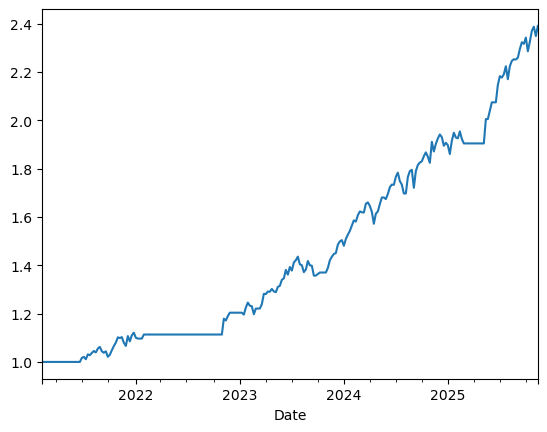

In [304]:
(
    (1 + buy_sell['Strat_Returns'])
    .cumprod()
).plot()

In [258]:
(
    (1 + buy_sell['Returns']*buy_sell['position'])
    .prod()
    -1
)

np.float64(1.3910271947644803)

<Axes: xlabel='Date'>

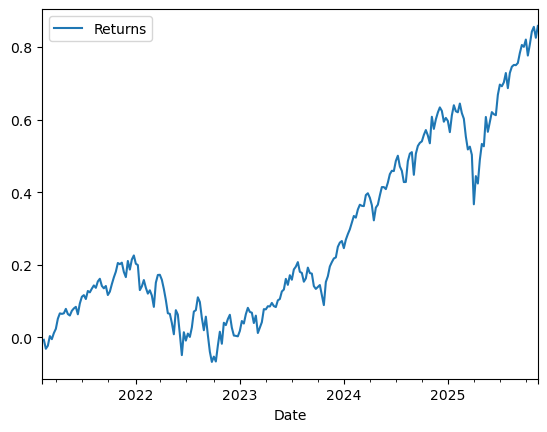

In [267]:
((1+spy_data_returns).cumprod() -1).plot()

In [275]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [292]:
buy_sell.loc[buy_sell['signal'] == 1].index

DatetimeIndex(['2021-07-02', '2022-02-04', '2022-11-11', '2023-01-20',
               '2023-03-24', '2023-10-06', '2023-11-10', '2025-05-16',
               '2025-05-30', '2025-06-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

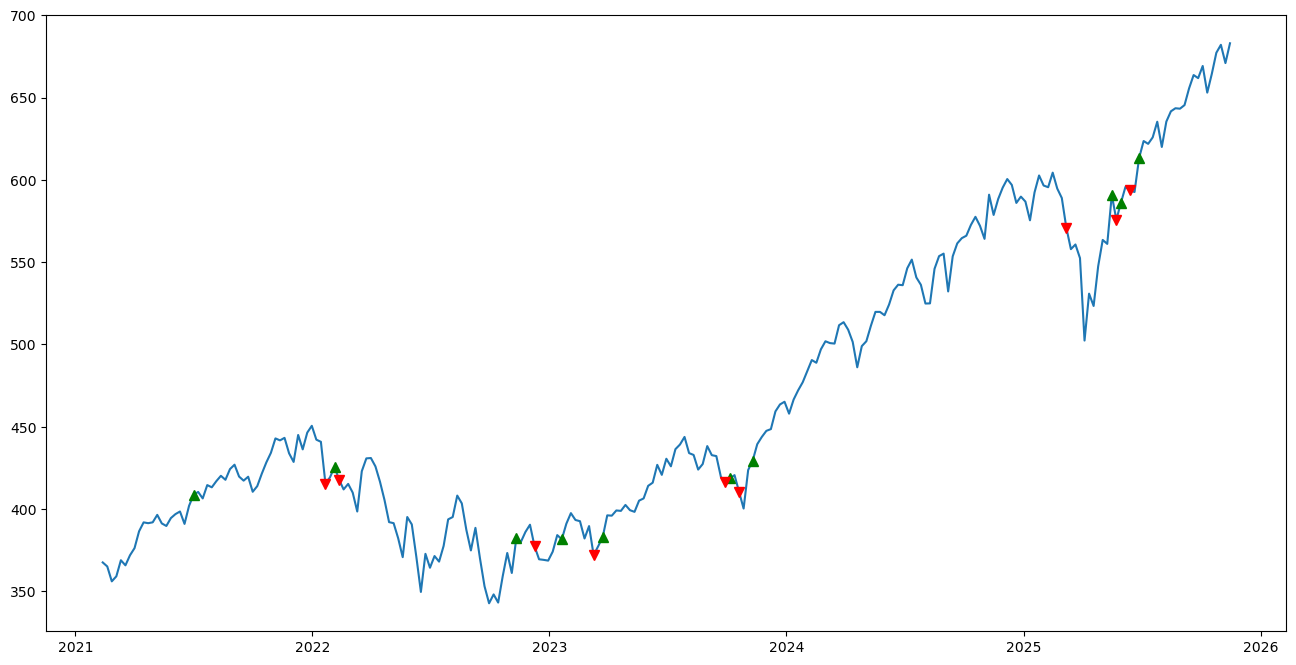

In [308]:
fig, ax = plt.subplots(figsize = [16,8])

ax.plot(buy_sell.index, buy_sell['Price'])
ax.plot(buy_sell.loc[buy_sell['signal'] == 1].index, buy_sell.loc[buy_sell['signal'] == 1, 'Price'], '^g', markersize = 7)
ax.plot(buy_sell.loc[buy_sell['signal'] == -1].index, buy_sell.loc[buy_sell['signal'] == -1, 'Price'], 'vr', markersize = 7)

## (1B) Mean Reverting Strategy

In [155]:
def setup_bollinger_strategy(
        old_df: pd.DataFrame,
        period: int,
        std_dev: int
) -> pd.DataFrame:

    df = old_df.copy()

    df[f'sma_{period}'] = \
    (
        df['Close']
        .rolling(period)
        .mean()
    )

    df['std_dev'] = \
    (
        df['Close']
        .rolling(period)
        .std()
    )

    df[f'upper_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] +
        (
            df['std_dev'] * std_dev
        )
    )

    df[f'lower_band_{std_dev}sd'] = \
    (
        df[f'sma_{period}'] -
        (
            df['std_dev'] * std_dev
        )
    )

    return df

<Axes: xlabel='Date'>

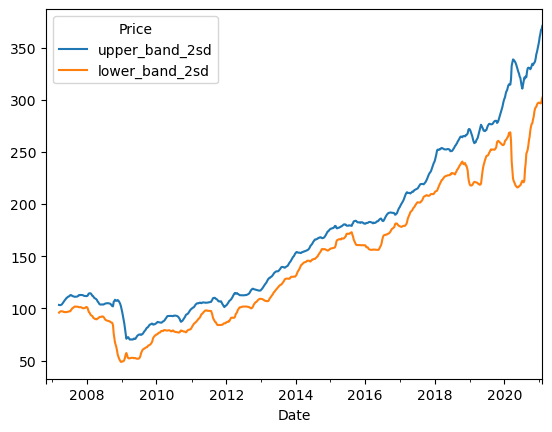

In [156]:
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2).iloc[:,-2:]
                             .plot()
)

In [157]:
spy_train_data_bollinger = \
(
    setup_bollinger_strategy(spy_train_data,
                             20,
                             2)
)

In [158]:
def generate_signals(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    
    signal = 0

    lst_signal = []

    for index, item in enumerate(df['Close']):
        if index ==0:
            lst_signal.append(0)
            continue
        prev_close = df['Close'].iloc[index-1] 
        close = df['Close'].iloc[index] 
        sma = df['sma_20'].iloc[index]
        lower_band = df['lower_band_2sd'].iloc[index]
        upper_band = df['upper_band_2sd'].iloc[index]

        if signal == 0:
            if (prev_close < lower_band) & (close > lower_band):
                signal = 1
            if (prev_close > upper_band) & (close < upper_band):
                signal = -1
        

        if signal == -1:
            if close < sma:
                signal = 0
        
        if signal == 1:
            if close > sma:
                signal = 0
        lst_signal.append(signal)

    df['signal'] = lst_signal
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [159]:
spy_train_data_bollinger = \
(
    generate_signals(spy_train_data_bollinger)
)

In [160]:
spy_train_data_bollinger

Price,Close,Volume,sma_20,std_dev,upper_band_2sd,lower_band_2sd,signal,position
Date,,,,,,,,
2006-11-03,95.749222,215045100,NaN,NaN,NaN,NaN,0,0.0
2006-11-10,96.941353,359047800,NaN,NaN,NaN,NaN,0,0.0
2006-11-17,98.470070,365694400,NaN,NaN,NaN,NaN,0,0.0
2006-11-24,98.420990,197045400,NaN,NaN,NaN,NaN,0,0.0
2006-12-01,98.329826,491307200,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...
2021-01-08,356.948853,425078700,328.430325,15.817265,360.064854,296.795796,0,0.0
2021-01-15,351.743439,306035100,329.741054,16.629482,363.000018,296.482089,0,0.0
2021-01-22,358.465546,213770000,331.759767,17.565110,366.889988,296.629546,0,0.0


In [161]:
def compute_strategy_return(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()


    df['daily_return'] = \
    (
        (
            df['Close']/
            df['Close'].shift(1)
        )
        .apply(np.log)
    )

    df['cum_return'] = \
    (
        df['daily_return']
        .cumsum()
        .apply(np.exp)
    )

    df['strategy_return'] = \
    (
        (
            df['position'] 
            *
            df['daily_return']
        )
        .cumsum()
        .apply(np.exp)
    )

    return df

In [162]:
spy_train_data_bollinger = \
(
    compute_strategy_return(spy_train_data_bollinger)
)

<Axes: xlabel='Date'>

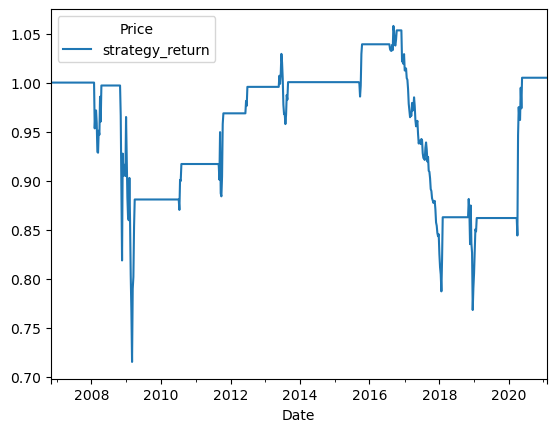

In [163]:
spy_train_data_bollinger[['strategy_return']].plot()

<Axes: xlabel='Date'>

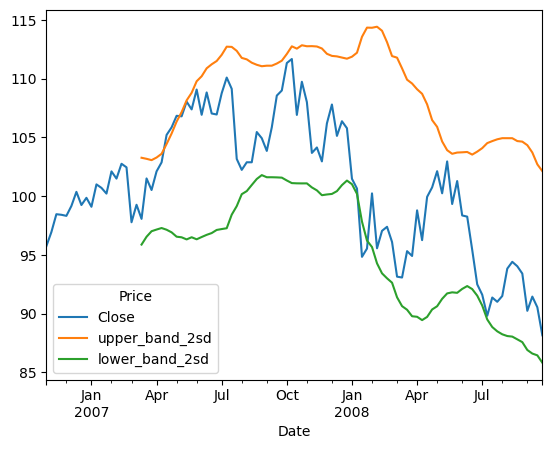

In [164]:
spy_train_data_bollinger[['Close','upper_band_2sd','lower_band_2sd']][:100].plot()

In [165]:
def compute_drawdown(old_df:pd.DataFrame) -> pd.DataFrame:
    df = old_df.copy()

    df['cum_max'] =\
    (
        df['strategy_return']
        .cummax()
    )

    df['drawdown'] = \
    (
        df['cum_max'] -
        df['strategy_return']
    )
    df['in_drawdown'] =\
    (
        df['cum_max'] !=
        df['strategy_return']
    )
    
    return df

In [166]:
spy_train_data_bollinger = \
    (
        compute_drawdown(spy_train_data_bollinger)
    )

In [167]:
spy_train_data_bollinger.iloc[-1]

Price
Close              362.987579
Volume              288507800
sma_20             336.310698
std_dev             17.201054
upper_band_2sd     370.712805
lower_band_2sd     301.908591
signal                      0
position                  0.0
daily_return         0.046566
cum_return           3.791024
strategy_return      1.004949
cum_max              1.057738
drawdown             0.052789
in_drawdown              True
Name: 2021-02-05 00:00:00, dtype: object

In [168]:
#Run back Testing on Test data
spy_test_data_bollinger = \
(
    setup_bollinger_strategy(spy_test_data,
                            20,
                            2)
)

In [169]:
spy_test_data_bollinger =\
(
    spy_test_data_bollinger
    .pipe(generate_signals)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [170]:
spy_test_data_bollinger

Price,Close,Volume,sma_20,std_dev,upper_band_2sd,lower_band_2sd,signal,position,daily_return,cum_return,strategy_return,cum_max,drawdown,in_drawdown
Date,,,,,,,,,,,,,,
2021-02-12,367.603119,226577300,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,True
2021-02-19,365.159607,246216800,NaN,NaN,NaN,NaN,0,0.0,-0.006669,0.993353,1.000000,1.000000,0.0,False
2021-02-26,356.106171,546504300,NaN,NaN,NaN,NaN,0,0.0,-0.025106,0.968725,1.000000,1.000000,0.0,False
2021-03-05,359.167755,640356900,NaN,NaN,NaN,NaN,0,0.0,0.008561,0.977053,1.000000,1.000000,0.0,False
2021-03-12,368.932587,497580800,NaN,NaN,NaN,NaN,0,0.0,0.026824,1.003617,1.000000,1.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-17,664.390015,457106900,634.945508,23.794619,682.534745,587.356271,0,0.0,0.017262,1.807357,1.147995,1.147995,0.0,False
2025-10-24,677.250000,337267400,639.021887,23.704735,686.431358,591.612417,0,0.0,0.019171,1.842340,1.147995,1.147995,0.0,False
2025-10-31,682.059998,374234900,643.445157,23.025969,689.497095,597.393219,0,0.0,0.007077,1.855425,1.147995,1.147995,0.0,False


### Result: Bollinger

<Axes: xlabel='Date'>

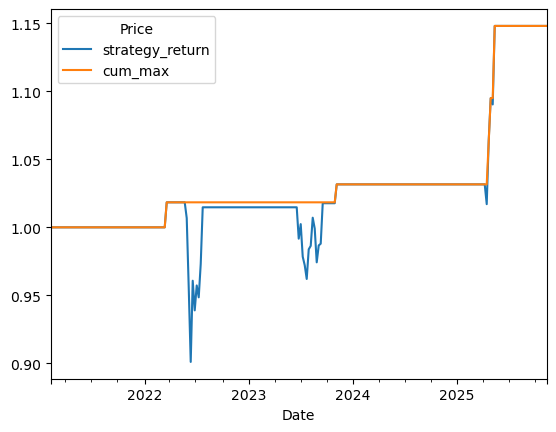

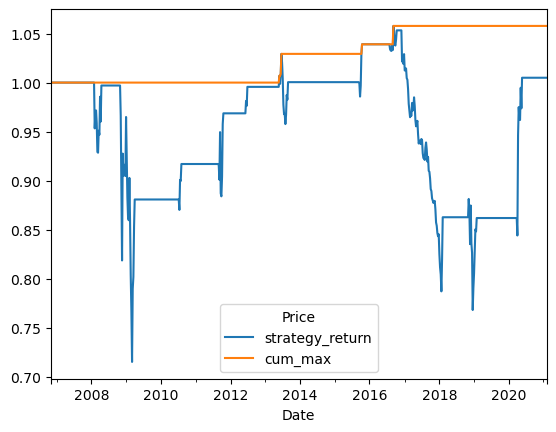

In [171]:
spy_test_data_bollinger[['strategy_return','cum_max']].plot()
spy_train_data_bollinger[['strategy_return','cum_max']].plot()

In [172]:
(spy_test_data_bollinger.iloc[-1,-4] 
-1
*100)

np.float64(-98.85200544011488)

In [173]:
print(
    'Test Return (%): ',(spy_test_data_bollinger.iloc[-1,-4]-1) *100,'\n'
    'Train Return (%): ',(spy_train_data_bollinger.iloc[-1,-4] -1) *100)

Test Return (%):  14.79945598851209 
Train Return (%):  0.4949021910505058


In [174]:
#Parameter Tuning: Bollinger Squeeze; Band Expansion; Breakout

#### Momentum Trading Strategy - RSI with MACD

In [175]:
def RSI(old_df, period=14):
    df = old_df.copy()
    delta = df['Close'].diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    df['rsi'] = 100 - 100 / (1 + rs)
    return df

In [176]:
def macd(old_df,
        macd_long: int = 26,
        macd_short: int = 12
        ) -> pd.DataFrame:
    
    #MACD - for trend direction
    
    df = old_df.copy()
    
    df['macd_long'] = \
    (    
        df['Close']
        .ewm(span = macd_long,
                adjust = False)
        .mean()
    )

    df['macd_short'] = \
    (
        df['Close']
        .ewm(span = macd_short,
             adjust = False)
        .mean()
    )

    df['macd'] = \
    (
        df['macd_short'] -
        df['macd_long']
    )

    df['signal_line'] = \
    (
        df['macd']
        .ewm(span = 9,
             adjust = False)
        .mean()
    )
    return df


In [177]:
def generate_signals_rsi_macd(
        old_df: pd.DataFrame
) -> pd.DataFrame:
    df = old_df.copy()
    df['signal'] = \
    (
        np
        .select(
            [
                (df['rsi'] > 30) & (df['macd'] > df['signal_line']),
                (df['rsi'] < 70) & (df['macd'] < df['signal_line'])
            ],
            [
                1,
                -1
            ],
            0
        )
    )
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
        .dropna()
    )
    return df

In [178]:
spy_train_data_rsi_macd =\
(
    spy_train_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [179]:
spy_test_data_rsi_macd = \
(
    spy_test_data
    .pipe(RSI)
    .pipe(macd)
    .pipe(generate_signals_rsi_macd)
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

<Axes: xlabel='Date'>

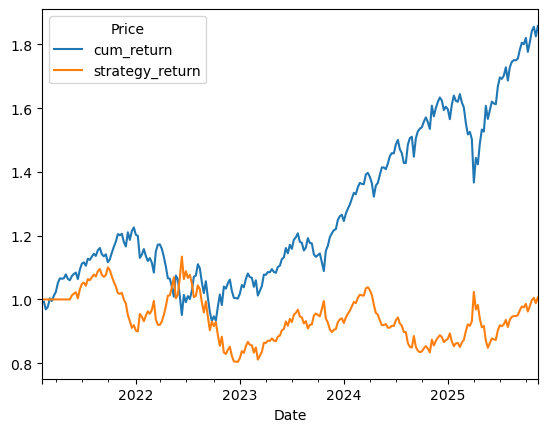

In [180]:
spy_test_data_rsi_macd[['cum_return','strategy_return']].plot()

In [181]:
def setup_buy_new_high(
        old_df,
        num_long_entry:int,
        num_short_entry: int,
        num_long_exit:int,
        num_short_exit: int) -> pd.DataFrame:
    
    df = old_df.copy()

    df['delta'] =\
    (
        df['Close']
        .diff()
    )

    df['up_trend'] =\
    (
        (
            df['delta'] > 0
        )
        .astype(int)
    )

    df['down_trend'] =\
    (
        (
            df['delta'] < 0
        )
        .astype(int)
    )
    
    #entry
    df['entry_short'] = \
    (
        df['up_trend']
        .rolling(num_short_entry)
        .sum() 
        == 
        num_short_entry
    )

    df['entry_long'] = \
    (
        df['down_trend']
        .rolling(num_long_entry)
        .sum() 
        == 
        num_long_entry
    )

    df['exit_short']  = \
    (
        df['down_trend']
        .rolling(num_short_exit)
        .sum() 
        == 
        num_short_exit
    )

    df['exit_long']  = \
    (
        df['up_trend']
        .rolling(num_long_exit)
        .sum() 
        == 
        num_long_exit
    )

    signals = []
    signal = 0

    for short_entry, long_entry, short_exit, long_exit in zip(
        df['entry_short'], 
        df['entry_long'],
        df['exit_short'], 
        df['exit_long']
    ):

        if signal == 0:
            if short_entry:
                signal = -1
            if long_entry:
                signal = 1

        elif signal == 1 and long_exit:
            signal = 0

        elif signal == -1 and short_exit:
            signal = 0

        signals.append(signal)

    df['signal'] = signals

    #stack buy
    df['position'] = \
    (
        df['signal']
        .ffill()
        .shift(1)
        .fillna(0)
    )
    return df

In [182]:
spy_train_data

Price,Close,Volume
Date,,
2006-11-03,95.749222,215045100
2006-11-10,96.941353,359047800
2006-11-17,98.470070,365694400
2006-11-24,98.420990,197045400
2006-12-01,98.329826,491307200
...,...,...
2021-01-08,356.948853,425078700
2021-01-15,351.743439,306035100
2021-01-22,358.465546,213770000


In [183]:
df_ret = pd.DataFrame()

for entry_l in range(2,10):
    for entry_s in range(2,10):
        for exit_l in range(2,10):
            for exit_s in range(2,10):
                a = spy_train_data.copy()
                a = \
                (
                    setup_buy_new_high(a,entry_l,entry_s,exit_l,exit_s)
                    .pipe(compute_strategy_return)
                    .pipe(compute_drawdown)
                )
                df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
df_ret['buy_and_hold'] = a['cum_return'].copy()

C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_24384\3793772336.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_24384\3793772336.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ret[f'stra_ret_entry{entry_l}_{entry_s}_exit{exit_l}_{exit_s}'] = a[['strategy_return']].copy()
C:\Users\TanFamily4\AppData\Local\Temp\ipykernel_24384\3793772336.py:14: PerformanceWarning: DataF

In [184]:
(df_ret.iloc[-1].sort_values(ascending=False)).head(30)

stra_ret_entry2_2_exit4_2    6.977944
stra_ret_entry4_5_exit9_6    6.687332
stra_ret_entry4_4_exit9_6    6.625738
stra_ret_entry2_2_exit5_2    6.424946
stra_ret_entry2_2_exit6_2    6.236919
stra_ret_entry6_2_exit9_2    5.105293
stra_ret_entry5_2_exit9_2    5.005460
stra_ret_entry6_3_exit9_4    4.949729
stra_ret_entry5_3_exit9_4    4.852937
stra_ret_entry4_3_exit9_4    4.852937
stra_ret_entry6_3_exit9_3    4.819213
stra_ret_entry3_5_exit9_6    4.784235
stra_ret_entry6_2_exit9_3    4.772418
stra_ret_entry3_4_exit9_6    4.740170
stra_ret_entry5_3_exit9_3    4.724974
stra_ret_entry6_5_exit9_5    4.712646
stra_ret_entry5_5_exit9_5    4.712646
stra_ret_entry3_5_exit9_5    4.712646
stra_ret_entry4_5_exit9_5    4.712646
stra_ret_entry6_5_exit9_3    4.685544
stra_ret_entry4_3_exit9_6    4.680453
stra_ret_entry5_2_exit9_3    4.679094
stra_ret_entry4_4_exit9_5    4.669241
stra_ret_entry3_4_exit9_5    4.669241
stra_ret_entry6_4_exit9_5    4.669241
stra_ret_entry5_4_exit9_5    4.669241
stra_ret_ent

In [185]:
a =\
(
    setup_buy_new_high(

        spy_test_data,
        2,
        2,
        4,
        2
    )
    .pipe(compute_strategy_return)
    .pipe(compute_drawdown)
)

In [186]:
spy_test_data

Price,Close,Volume
Date,,
2021-02-12,367.603119,226577300
2021-02-19,365.159607,246216800
2021-02-26,356.106171,546504300
2021-03-05,359.167755,640356900
2021-03-12,368.932587,497580800
...,...,...
2025-10-17,664.390015,457106900
2025-10-24,677.250000,337267400
2025-10-31,682.059998,374234900


<Axes: xlabel='Date'>

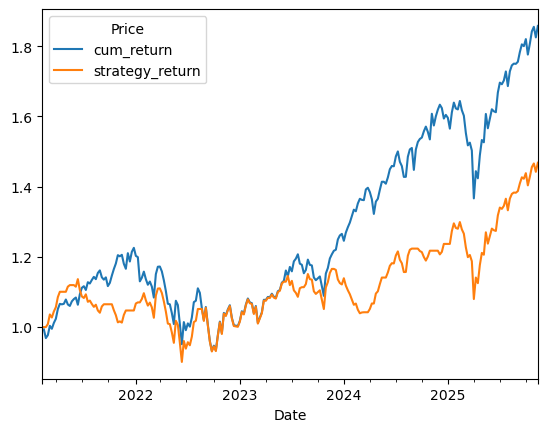

In [187]:
a[['cum_return','strategy_return']].plot()

## Mixed Strategies